In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [51]:
print("TF Version:", tf.__version__)

TF Version: 1.12.0


# Part 1: Gaussian

In [52]:
sess = tf.InteractiveSession()

In [53]:
X, Y = np.mgrid[-4.0:4:0.01, -4.0:4:0.01]
xs = tf.constant(X.astype(np.float32))
ys = tf.constant(Y.astype(np.float32))
tf.global_variables_initializer().run() #init variables

In [54]:
zs = tf.exp(-(xs**2+ys**2)/2.0)

In [55]:
plt.imshow(zs.eval())
plt.tight_layout()
plt.show()

In [56]:
# Sine function 
ss = tf.sin(-(xs**2+ys**2)/2.0)

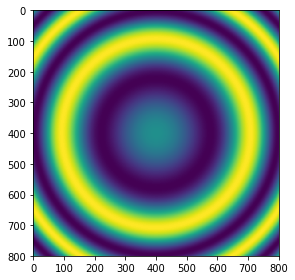

In [57]:
plt.imshow(ss.eval())
plt.tight_layout()
plt.show()

In [58]:
# Gabor filter: sin * gaussian 
zss = ss*zs
plt.imshow(zss.eval())
plt.tight_layout()
plt.show()
sess.close

<bound method InteractiveSession.close of <tensorflow.python.client.session.InteractiveSession object at 0x1529d7748>>

# Part 2 
Computing the Mandelbrot set. 

In [36]:
sess2 = tf.InteractiveSession()

In [41]:
# Fractal processing and image methods 

def processFractal(a):
    """Display an array of iteration counts as a
    colorful picture of a fractal."""
    
    a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
    img = np.concatenate([
        10+20*np.cos(a_cyclic),
        30+50*np.sin(a_cyclic),
        155-80*np.cos(a_cyclic)], axis=2)
    img[a==a.max()] = 0
    a = img
    a = np.uint8(np.clip(a, 0, 255))
    return a

def draw_fractal(grid, spacing, julia_c=None):
    l,r,b,t = grid[0], grid[1], grid[2], grid[3]
    print(l,r,b,t)
    Y, X = np.mgrid[b:t:spacing, l:r:spacing]
    Z = X+1j*Y


    xs = tf.constant(Z.astype(np.complex64))
    zs = tf.Variable(xs)
    ns = tf.Variable(tf.zeros_like(xs, tf.float32))

    tf.global_variables_initializer().run() #init variables

    #Mandelbrot Set
    #Compute the new values of z: z^2 + x
    if julia_c: 
        zs_ = zs*zs + julia_c
    else :
        zs_ = zs*zs + xs

    # Have we diverged with this new value?
    not_diverged = tf.abs(zs_) < 4

    # Operation to update the zs and the iteration count.
    #
    # Note: We keep computing zs after they diverge! This
    # is very wasteful! There are better, if a little
    # less simple, ways to do this.
    #
    step = tf.group(zs.assign(zs_), ns.assign_add(tf.cast(not_diverged, tf.float32)) )

    #run
    for i in range(200):
        step.run()

    fig = plt.figure(figsize=(16,10))

    plt.imshow(processFractal(ns.eval()), extent=grid)
    plt.tight_layout(pad=0)
    plt.show()

### part 2a: Higher Resolution  

-2 1 -1.3 1.3


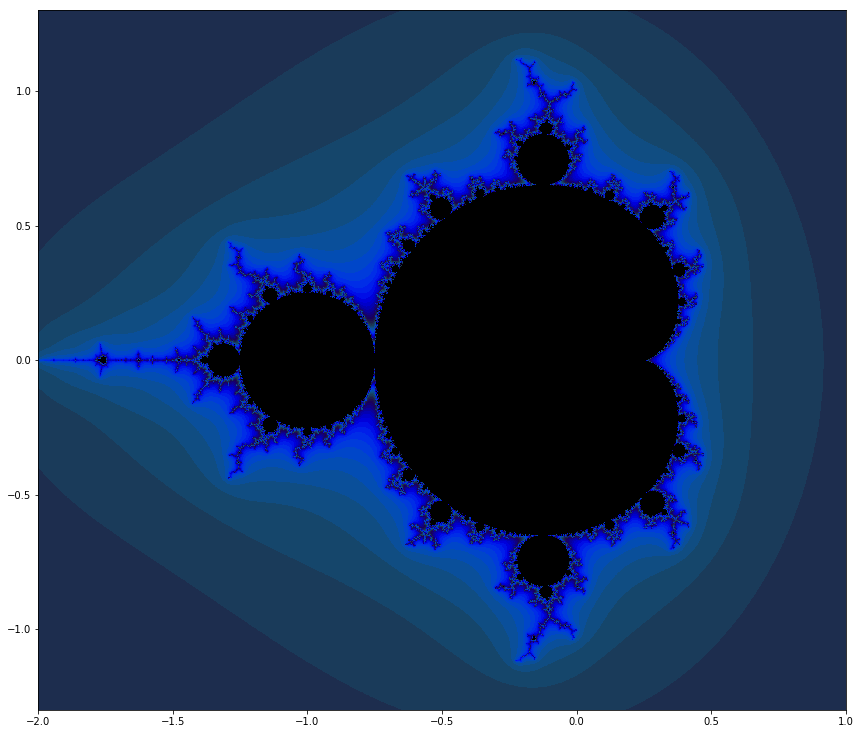

In [44]:
# Higher resolution Mandelbrot set: 
# Use NumPy to create a 2D array of complex numbers on [-2,2]x[-2,2]
grid = [-2,1,-1.3,1.3]
draw_fractal(grid, 0.001)

### Part 2b: Zoomed Mandelbrot Set

In [63]:
# Zoom into part of the Mandelbrot set 
zoomed_grid = [-0.85,-0.7,0,0.25]
draw_fractal(zoomed_grid, 0.0001)

-0.85 -0.7 0 0.25


### Part 2c: Julia Set
where c = -0.835-0.2321i

In [40]:
# Show a julia set rather than the Mandelbrot Set 
draw_fractal([-1.75,1.75,-1.3,1.3], 0.001, julia_c=-0.835-1j*0.2321)

-1.75 1.75 -1.3 1.3


In [15]:
sess2.close()

# Part 3 : Implementation of Chosen Fractal 
## Barnsley's Fern

### Naive implementation

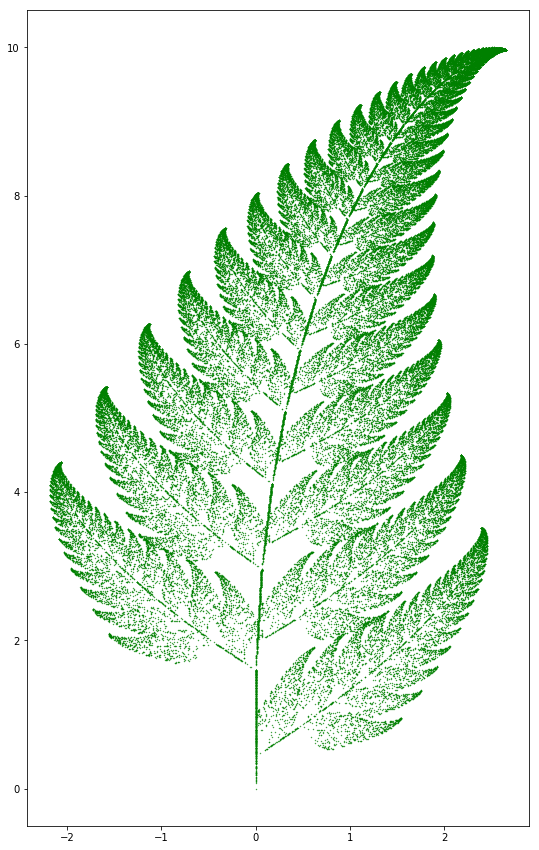

In [15]:
#%%writefile main.py

# Author: Naziah SIDDIQUE 
# Last update: 22/09/2019

# Barnsley's fern using numpy as it is faster than tensorflow 
import random
import matplotlib.pyplot as plt

def barnsley_arrays(points=1000):
    X = [0]
    Y = [0]

    for n in range(1, points):
        r = random.uniform(0, 100)
        if r < 1.0:
            x = 0
            y = 0.16*Y[n-1]
        elif r < 86.0:
            x = 0.85*X[n-1] + 0.04*Y[n-1]
            y = -0.04*X[n-1] + 0.85*Y[n-1]+1.6
        elif r < 93.0:
            x = 0.2*X[n-1] - 0.26*Y[n-1]
            y = 0.23*X[n-1] + 0.22*Y[n-1] + 1.6
        else:
            x = -0.15*X[n-1] + 0.28*Y[n-1]
            y = 0.26*X[n-1] + 0.24*Y[n-1] + 0.44
        X.append(x)
        Y.append(y)
        
    return X, Y


def plot_barnsley(X, Y, figsize=[9,15]):
    '''Make a plot'''
    plt.figure(figsize=figsize)
    plt.scatter(X,Y,color = 'g',marker = '.', s=0.5)
    plt.show()

def main():
    X, Y = barnsley_arrays(100000)
    plot_barnsley(X, Y)
    
if __name__ == '__main__':
    main()

### Part 3a: Using Tensorflow 

In [3]:
%%writefile barnsley_fern_tf.py

# Barnsley's fern TENSORFLOW VERSION
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

sess = tf.Session()

# Adding points to fractal
iterations = 10000

# tensors for storing x,y coords
X = tf.Variable(np.zeros(iterations))
Y = tf.Variable(np.zeros(iterations))

# random no.s array 
randos = np.random.uniform(low=0.0, high=100.0, size=(iterations,))

# Initialise tensors 
tf.global_variables_initializer().run()

# Run step several times to generate each coord
for n in range(1,iterations):
    r = randos[n]
    prev_y = tf.gather(Y,[n-1])
    prev_x = tf.gather(X,[n-1])
    if r < 1.0:
        x = 0
        y = 0.16*prev_y
    elif r < 86.0:
        x = 0.85*prev_x + 0.04*prev_y
        y = -0.04*prev_x + 0.85*prev_y+1.6
    elif r < 93.0:
        x = 0.2*prev_x - 0.26*prev_y
        y = 0.23*prev_x + 0.22*prev_y + 1.6
    else:
        x = -0.15*prev_x + 0.28*prev_y
        y = 0.26*prev_x + 0.24*prev_y + 0.44
        
    X = tf.scatter_update(X, [n], x)
    Y = tf.scatter_update(Y, [n], y)

# Plot coordinates 
plt.figure(figsize = [6,10])
plt.scatter(X.eval(),Y.eval(),color = 'g', marker = '.', s=0.5)
plt.show()
sess.close()

Writing barnsley_fern_tf.py


In [16]:
%%writefile README.md
## Barnsley Fern
---
Author: Naziah SIDDIQUE 
Last update: 22/09/2019

### Result Figure
![BarnsleyFern](figure.png)

Writing README.md
